In [1]:
grand_prix = "Australia"

In [3]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib import font_manager
from matplotlib.ticker import FixedLocator

import seaborn as sns
from sklearn.linear_model import LinearRegression

from timple.timedelta import strftimedelta
from datetime import datetime, timedelta


import fastf1 as f1
import fastf1.plotting
from fastf1.core import Laps
from fastf1.ergast import Ergast
from fastf1 import utils

ergast = Ergast(result_type='pandas')

with open("../season_info.json") as file:
    season_info = json.loads(file.read())
teams = season_info["teams"]
team_colours = season_info["team_colours"]
tyre_colours = season_info["tyre_colours"]
drivers = season_info["drivers"]
races = season_info["races"]
current_race = races[grand_prix]


fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme="fastf1", misc_mpl_mods=True)

font_files = font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

font = font_manager.FontProperties(family="Formula1", weight="normal", style="normal", size=16)

data = f1.get_session(year=2024, gp=grand_prix, identifier="Q")
data.load()
LAPS = data.laps

all_laps_by_team = dict()

for team1 in teams:

    team_data = LAPS[LAPS["Team"] == team1]

    all_laps_by_team[team1] = team_data.reset_index()


circuit_info = data.get_circuit_info()


core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.3.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading d

In [4]:
q1, q2, q3 = LAPS.split_qualifying_sessions()

In [5]:
ver_lap = q3.pick_driver("VER").pick_fastest()
lec_lap = q3.pick_driver("LEC").pick_fastest()


ver_tel = ver_lap.get_car_data().add_distance()
lec_tel = lec_lap.get_car_data().add_distance()

c:\Users\maxvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


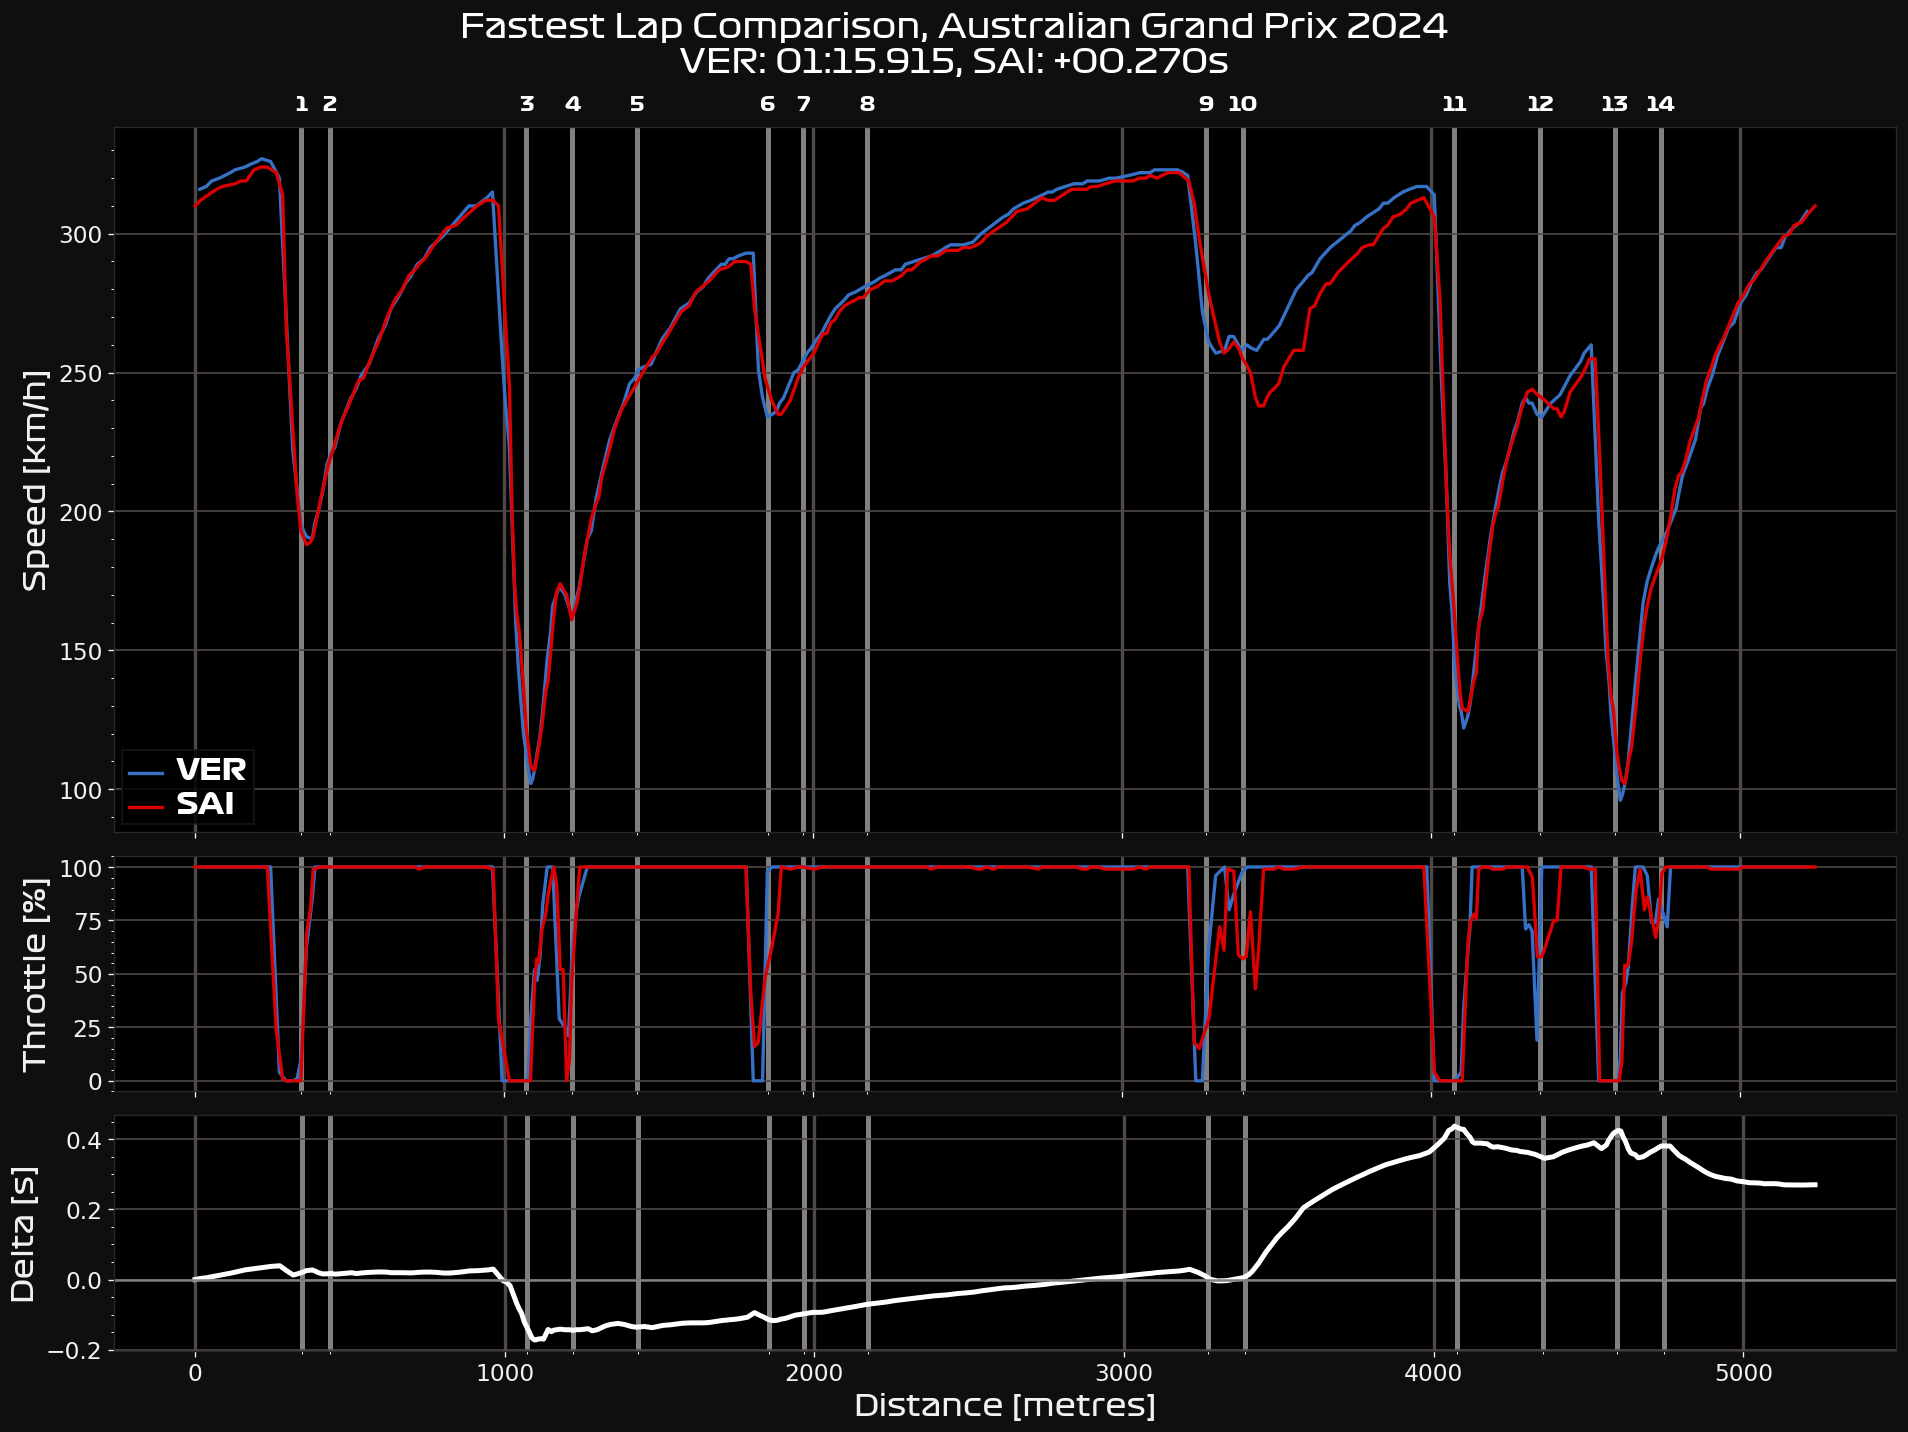

In [7]:
'''TELEMETRY DATA'''

'''SETUP'''
driver1 = "VER"
driver2 = "SAI"

axis_fontsize = 18
tick_fontsize = 14

team1 = drivers[driver1]["Team"]
team2 = drivers[driver2]["Team"]
team1_colour = team_colours[team1]
team2_colour = team_colours[team2]

lap1 = q3.pick_driver(driver1).pick_fastest()
lap2 = q3.pick_driver(driver2).pick_fastest()
lap1_tel = lap1.get_car_data().add_distance()
lap2_tel = lap2.get_car_data().add_distance()

delta_time, ref_tel, compare_tel = utils.delta_time(lap1, lap2)


circuit_info = data.get_circuit_info()
v_min = lap1_tel["Speed"].min()
v_max = lap1_tel["Speed"].max()

'''GRAPH START'''

fig, ax = plt.subplots(nrows=3, height_ratios=[3, 1, 1], figsize=(16,12), dpi=120, facecolor="#0F0F0F")

# CORNER LINES
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner["Number"]}{corner["Letter"]}"
    ax[0].text(corner["Distance"], v_max+20, txt, va="center_baseline", ha="center", size="large", fontname="Formula1", color="white")

# CORNER MINOR AXIS LINE LOCATIONS
corner_location = circuit_info.corners["Distance"]
minor_tick_locations = list()
for corner in corner_location:
    minor_tick_locations.append(corner)


ax[0].plot(lap1_tel["Distance"], lap1_tel["Speed"], color=team1_colour, label=driver1, linewidth=2)
ax[0].plot(lap2_tel["Distance"], lap2_tel["Speed"], color=team2_colour, label=driver2, linewidth=2)

ax[1].plot(lap1_tel["Distance"], lap1_tel["Throttle"], color=team1_colour, label=driver1, linewidth=2)
ax[1].plot(lap2_tel["Distance"], lap2_tel["Throttle"], color=team2_colour, label=driver2, linewidth=2)

ax[2].plot(ref_tel["Distance"], delta_time, color="white", linewidth=3)
ax[2].axhline(y=0, color="gray")

l = ax[0].legend(facecolor="black", labelcolor="white")
plt.setp(l.texts, family="Formula1", size=axis_fontsize)


ax[0].get_xaxis().set_ticklabels([])
ax[1].get_xaxis().set_ticklabels([])
ax[2].set_xlabel("Distance [metres]", fontname="Formula1", fontsize=axis_fontsize)

y_labels = ["Speed [km/h]", "Throttle [%]", "Delta [s]"]
for n in range(0,3):
    ax[n].tick_params(labelsize=tick_fontsize)
    ax[n].patch.set_facecolor("black")
    ax[n].set_ylabel(y_labels[n], fontname="Formula1", fontsize=axis_fontsize)

    ax[n].xaxis.set_minor_locator(FixedLocator(minor_tick_locations))
    ax[n].grid(which="minor", linestyle="-", linewidth=3, color="gray")
    ax[n].grid(which="minor", axis="y", linewidth=0)
    ax[n].grid(which="major", axis="x", linestyle="-", linewidth=2)




fastest_lap_time = strftimedelta(lap1["LapTime"], "%m:%s.%ms")
diff = strftimedelta(lap2["LapTime"] - lap1["LapTime"], "%s.%ms")
plt.suptitle(f"Fastest Lap Comparison, {data.event["EventName"]} {data.event.year}\n{driver1}: {fastest_lap_time}, {driver2}: +{diff}s",
             fontsize=20, fontname="Formula1", color="white")

fig.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.05)
plt.show()
